In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, Adam
from keras.models import Sequential
from keras.layers.core import Dense

from mydatools import img_plot

%matplotlib inline

Using Theano backend.
Using cuDNN version 5103 on context None
Mapped name None to device cuda: Tesla K80 (0000:00:1E.0)


In [2]:
path = 'data/input/all/'
# path = 'data/input/sample/'

In [3]:
def get_batches(dirname, gen=ImageDataGenerator(), shuffle=True, batch_size=4, class_mode='categorical',
                target_size=(224,224)):
    return gen.flow_from_directory(dirname, target_size=target_size,
            class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

def get_data(path, target_size=(224,224)):
    batches = get_batches(path, shuffle=False, batch_size=1, target_size=target_size)
    # 这里shuffle不能为True 否则X,y不对应
    X = np.concatenate([batches.next()[0] for i in range(batches.samples)])
    y = np.concatenate([batches.next()[1] for i in range(batches.samples)])
    return X, y

def get_class(a_onehot):
    return a_onehot.argmax(axis=1)

## VGG16 finetune

删除一些层 重新进行训练

注意：只用重新训练后面几层，前面的卷积层带有图片的一些基础形状的识别

目标图片越接近vgg的图片分类，训练的层数可以少

而如果目标图片越不接近vgg的图片分类，可以多训练几层，甚至卷积层

In [4]:
def fit_model(model, batches, val_batches, nb_epoch=1):
    model.fit_generator(batches, samples_per_epoch=batches.samples, nb_epoch=nb_epoch, 
                        validation_data=val_batches, nb_val_samples=val_batches.samples)

In [5]:
# is_shuffle: accuracy
# T F: 0.95 0.95
# T T: 0.95 0.95
# F T: 0.95 0.95 需要更小的lr，以及更大的epoch
#                因为不shuffle，所以每个epoch的sub_batch都不变，需要更大的epoch；而sub_batch带有更多的数据，训练需要更小的lr
# F F: 0.95 0.95 （与上面一致）
tra_batches = get_batches(path+'train', shuffle=True, batch_size=64)
val_batches = get_batches(path+'val', shuffle=False, batch_size=64)

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [6]:
# X_tra, y_tra = get_data(path+'train')
X_val, y_val = get_data(path+'val')

# y_tra_class = get_class(y_tra)
y_val_class = get_class(y_val)

Found 2500 images belonging to 2 classes.


In [7]:
# vgg16
base_model = VGG16()

In [8]:
# 最后一层改为输出2个节点
x = base_model.layers[-2].output
x = Dense(2, activation='softmax')(x)
model = Model(base_model.input, x)

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [10]:
# 将剩余的层设置为不可训练
for layer in model.layers:
    layer.trainable = True
    
for layer in model.layers[:-2]:
    layer.trainable = False
# first_dense_index = [i for i, layer in enumerate(model.layers) if type(layer) is Dense][0]
# for layer in model.layers[:first_dense_index]:
#     layer.trainable = False

In [11]:
# opt = Adam(lr=1e-6)
opt = RMSprop(lr=1e-5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
# model.fit(X_tra, y_tra, batch_size=64, epochs=5, validation_data=(X_val, y_val))

In [13]:
# 注意steps_per_epoch是每个epoch训练次数，每次使用的数据是batch_size个
# 所以一般这个参数设置为batches.samples//batches.batch_size
model.fit_generator(tra_batches, steps_per_epoch=tra_batches.samples//tra_batches.batch_size, 
                    epochs=1,
                    validation_data=val_batches, validation_steps=val_batches.samples//val_batches.batch_size)

Epoch 1/2
351/351 [==============================] - 455s - loss: 0.1044 - acc: 0.9619 - val_loss: 0.0818 - val_acc: 0.9700
Epoch 2/2
351/351 [==============================] - 453s - loss: 0.0334 - acc: 0.9889 - val_loss: 0.0853 - val_acc: 0.9713


In [ ]:
# # 将剩余的层设置为不可训练
# for layer in model.layers:
#     layer.trainable = True
    
# first_dense_index = [i for i, layer in enumerate(model.layers) if type(layer) is Dense][0]
# for layer in model.layers[:first_dense_index]:
#     layer.trainable = False

In [11]:
# opt = RMSprop(lr=1e-5)
# model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# # 注意steps_per_epoch是每个epoch训练次数，每次使用的数据是batch_size个
# # 所以一般这个参数设置为batches.samples//batches.batch_size
# model.fit_generator(tra_batches, steps_per_epoch=tra_batches.samples//tra_batches.batch_size, 
#                     epochs=1,
#                     validation_data=val_batches, validation_steps=val_batches.samples//val_batches.batch_size)

Epoch 1/2
351/351 [==============================] - 455s - loss: 0.1044 - acc: 0.9619 - val_loss: 0.0818 - val_acc: 0.9700
Epoch 2/2
351/351 [==============================] - 453s - loss: 0.0334 - acc: 0.9889 - val_loss: 0.0853 - val_acc: 0.9713


## View prediction result

In [14]:
pred_proba = model.predict(X_val)
pred_class = get_class(pred_proba)

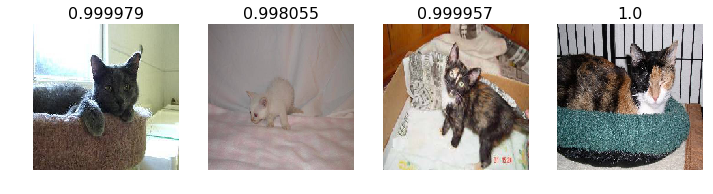

In [15]:
# 1. 展示正确的结果
cond = y_val_class == pred_class
show_imgs = X_val[cond][:4]
show_imgs_label = pred_proba[cond][:, 0][:4]
img_plot.img_plots(show_imgs, titles=show_imgs_label)

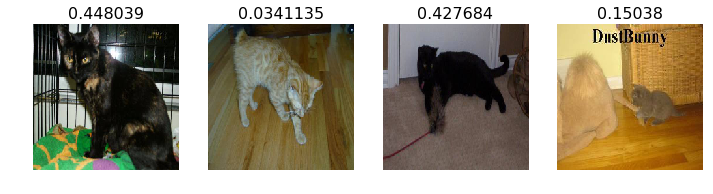

In [16]:
# 2. 展示错误的结果
cond = y_val_class != pred_class
show_imgs = X_val[cond][:4]
show_imgs_label = pred_proba[cond][:, 0][:4]
img_plot.img_plots(show_imgs, titles=show_imgs_label)

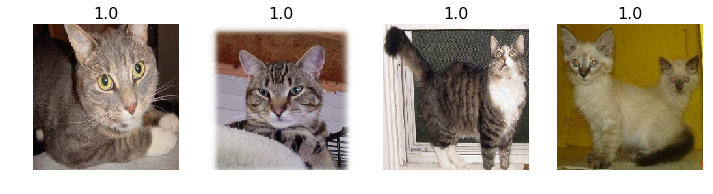

In [17]:
# 3. 展示最正确的结果
# 猫
class_id = 0
cond = (y_val_class == class_id) & (y_val_class == pred_class)
idx = pred_proba[cond][:, class_id].argsort()[::-1][:4]
show_imgs = X_val[cond][idx]
show_imgs_label = pred_proba[cond][idx][:, class_id]
img_plot.img_plots(show_imgs, titles=show_imgs_label)

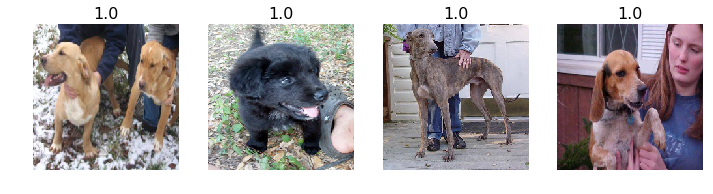

In [18]:
# 狗
class_id = 1
cond = (y_val_class == class_id) & (y_val_class == pred_class)
idx = pred_proba[cond][:, class_id].argsort()[::-1][:4]
show_imgs = X_val[cond][idx]
show_imgs_label = pred_proba[cond][idx][:, class_id]
img_plot.img_plots(show_imgs, titles=show_imgs_label)

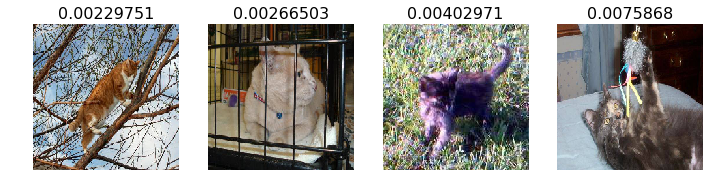

In [19]:
# 4. 展示最错误的结果
# 猫
class_id = 0
cond = (y_val_class == class_id) & (y_val_class != pred_class)
idx = pred_proba[cond][:, class_id].argsort()[:4]
show_imgs = X_val[cond][idx]
show_imgs_label = pred_proba[cond][idx][:, class_id]
img_plot.img_plots(show_imgs, titles=show_imgs_label)

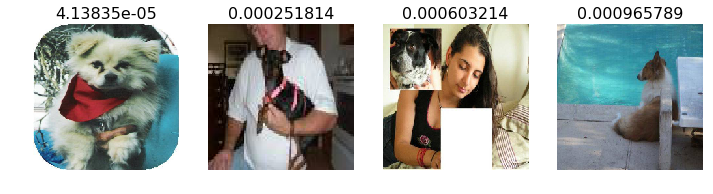

In [20]:
# 狗
class_id = 1
cond = (y_val_class == class_id) & (y_val_class != pred_class)
idx = pred_proba[cond][:, class_id].argsort()[:4]
show_imgs = X_val[cond][idx]
show_imgs_label = pred_proba[cond][idx][:, class_id]
img_plot.img_plots(show_imgs, titles=show_imgs_label)

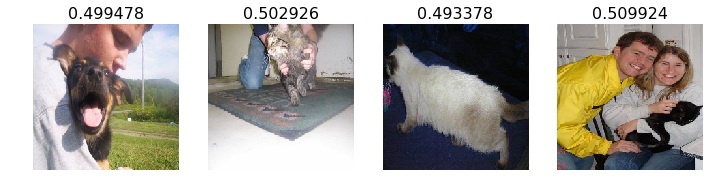

In [21]:
# 5. 最不确定的结果
idx = np.abs(pred_proba[:, 0] - 0.5).argsort()[:4]
show_imgs = X_val[idx]
show_imgs_label = pred_proba[idx][:, 0]
img_plot.img_plots(show_imgs, titles=show_imgs_label)

## 预测

In [22]:
test_batches = get_batches(path+'test', shuffle=False, batch_size=1, class_mode=None)

Found 12500 images belonging to 1 classes.


In [ ]:
test_prob = model.predict_generator(test_batches, test_batches.samples)

In [ ]:
res_df = pd.DataFrame({
    'id': [f[8:-4] for f in test_batches.filenames],
    'label': test_prob[:, batches.class_indices['dog']],
})
res_file_path = './data/output/vgg16_finetune.csv'

# 将label限制在0.05~0.95
res_df['label'] = res_df['label'].values.clip(min=0.05, max=0.95)

res_df.to_csv(res_file_path, index=False)

In [ ]:
from IPython.display import FileLink
FileLink(res_file_path)

In [ ]:
res_df['id'] = res_df['id'].apply(np.int)
res_df.sort_values('id')